# Task

You are given a set of images that are classified by a model trained on Imagenet as goldfish (class 1). Your task is to compute a strip of pixels of size
10 x 100 (i.e., the first 10 rows of an image of size 100 x 100), which when pasted into *each* of the original images makes the model think it is a shark (class 2) with returned probability of at least 0.5.

Note: you can score half of the points in this task if you compute a strip that works for at least one image from the list.

Important: your code needs to compute the desired strip in at most 2 minutes - it is possible to do it in less than 10 seconds on colab with GPU.


## Data

Below you can find a piece of code that download a zipfile and displays the images. Note that here the images are in their original resolution that will be later scaled down to 100 x 100.

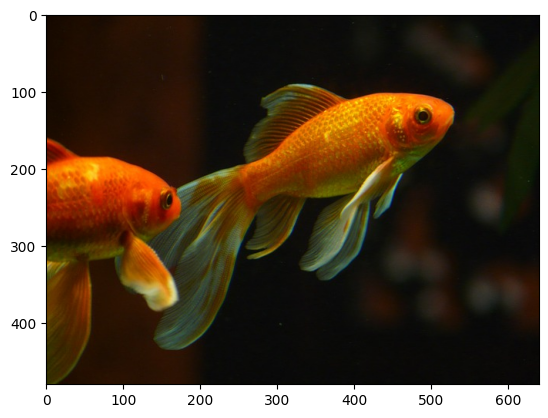

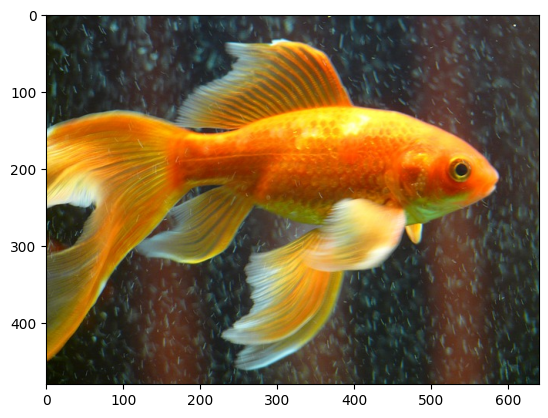

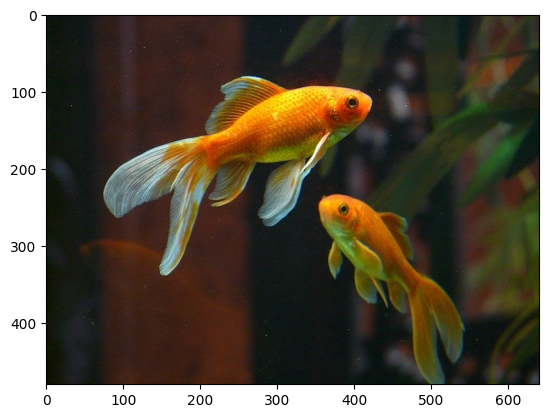

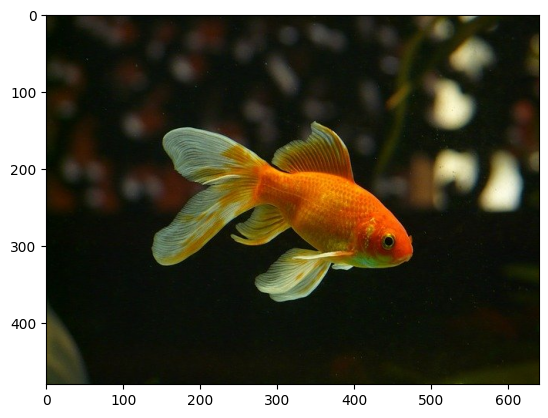

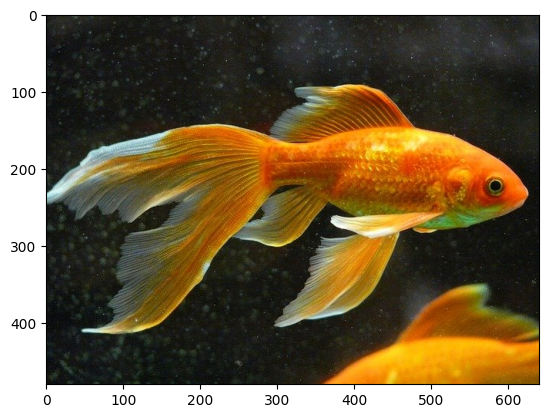

In [ ]:
import requests, zipfile
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

url = "https://www.mimuw.edu.pl/~cygan/goldfish.zip"
request = requests.get(url)
zipfile = zipfile.ZipFile(BytesIO(request.content))
images = []
for filename in zipfile.namelist():
  if filename.endswith('jpg'):
    ifile = zipfile.open(filename)
    img = Image.open(ifile)
    images.append(img)
    plt.imshow(img)
    plt.show()

## Model

We will be using the `mobilenet_v2` model, solving the classification problem on the Imagenet dataset. As far as this task is concerned you do not have to know the details of the model's architecture, we are treating it as a black box, in particular the model's weights will be frozen and cannot be changed.



In [ ]:
from torchvision.models import mobilenet_v2, MobileNet_V2_Weights
import numpy as np
import torch
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = mobilenet_v2(weights=MobileNet_V2_Weights.IMAGENET1K_V1)
model.to(device)
model.eval()

cpu


Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 32.7MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

## Data preprocessing

In order to evaluate the model on the given images, we first scale them down to size 100x100 (which is an arbitrary choice selected for this task), but also normalize them using the following normalization transform.


In [ ]:
normalize_colors = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225])

SIZE = 100
resize = transforms.Compose([transforms.Resize((SIZE, SIZE)),
                             transforms.ToTensor()])

## Evaluation

Below is a piece of code that takes an input a given image and a tensor of size 3x10x100 with values between 0 and 1, and:
* rescales the image to size 100x100,
* replaces the first chunk of size 10x100 by the given tensor (for all 3 colors),
* normalizes the colors of the obtained image,
* evaluates the model and returns the probabilities of the image being classified as goldfish and shark respectively.

In [ ]:
STRIP_HEIGHT = 10

def calc_predictions(image, strip):
  assert strip.shape == (3, STRIP_HEIGHT, SIZE)
  assert torch.ge(strip, 0.).all()
  assert torch.le(strip, 1.0).all()
  img_tensor = resize(image.convert("RGB")).to(device)
  # At this point img_tensor is of shape (3, SIZE, SIZE)
  ############# Important line - replacing part of the image ################
  img_tensor[:, :STRIP_HEIGHT, :] = strip.to(device)
  img_tensor = normalize_colors(img_tensor)
  # We have to add one more dimention representing the bath.
  img_tensor = img_tensor.unsqueeze(0)
  probabilities = torch.nn.functional.softmax(model(img_tensor)[0], dim=-1)
  # Class 1 in Imagenet is a goldfish, 2 is a shark
  return probabilities[1], probabilities[2]

In [ ]:
for im in images:
  p_goldfish, p_shark = calc_predictions(im, torch.zeros((3, STRIP_HEIGHT, SIZE)))
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')

Probability of being a goldfish is 0.9991119503974915, shark is 9.153951902041157e-12.
Probability of being a goldfish is 0.9996258020401001, shark is 6.371141136364555e-13.
Probability of being a goldfish is 0.9545313715934753, shark is 2.6417564316649766e-11.
Probability of being a goldfish is 0.9552145004272461, shark is 2.3239047405171354e-12.
Probability of being a goldfish is 0.9978420734405518, shark is 2.3563922623044686e-13.


## TO IMPLEMENT

Here you have to implement the function that finds the strip. Please don't modify the name of the function, as later it will be automatically tested.


Epoch 0


<ipython-input-19-be7920d45d2d>:19: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  loss = -torch.nn.functional.log_softmax(pred)[2]


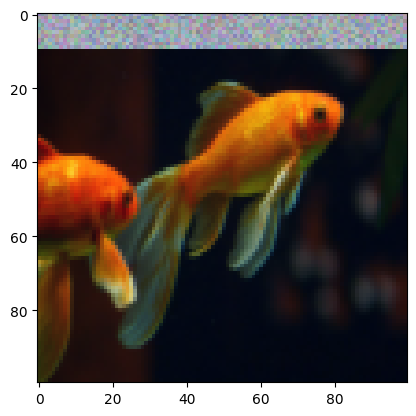

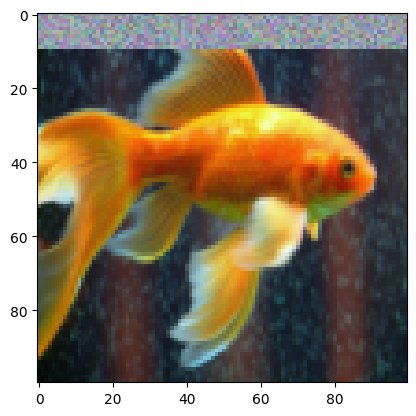

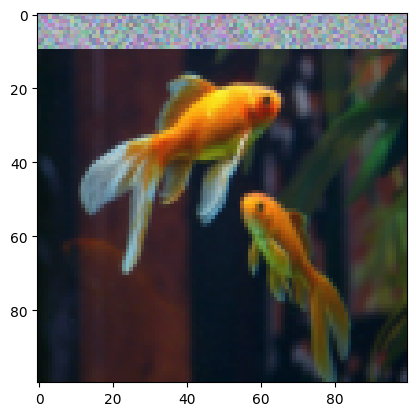

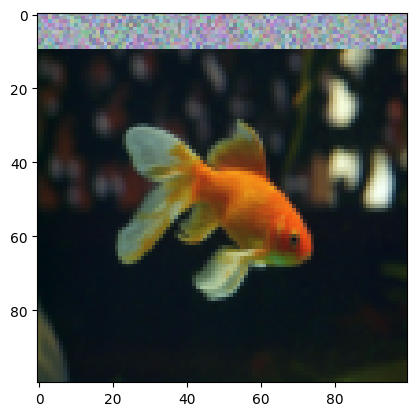

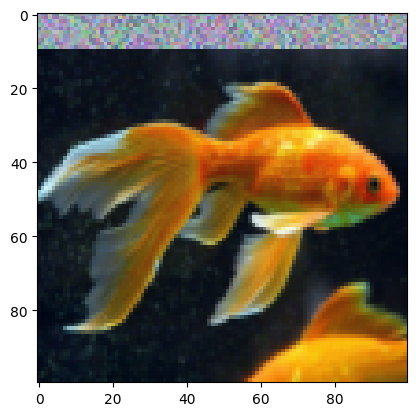

tensor(23.3575) [tensor(23.9394), tensor(26.0128), tensor(21.3030), tensor(18.8712), tensor(26.6610)]
Epoch 1
tensor(20.2701) [tensor(20.1152), tensor(22.4594), tensor(16.4612), tensor(17.2982), tensor(25.0167)]
Epoch 2
tensor(18.5407) [tensor(18.2186), tensor(21.2711), tensor(13.7391), tensor(16.1001), tensor(23.3746)]
Epoch 3
tensor(17.3780) [tensor(17.2836), tensor(20.2189), tensor(11.8280), tensor(15.1393), tensor(22.4204)]
Epoch 4
tensor(16.7845) [tensor(17.0119), tensor(19.7116), tensor(10.9920), tensor(14.5283), tensor(21.6789)]
Epoch 5
tensor(16.2767) [tensor(16.2966), tensor(19.0695), tensor(10.6510), tensor(14.0555), tensor(21.3108)]
Epoch 6
tensor(15.7955) [tensor(15.4500), tensor(18.8424), tensor(10.0698), tensor(13.6948), tensor(20.9206)]
Epoch 7
tensor(15.3778) [tensor(14.7915), tensor(18.6830), tensor(9.7884), tensor(13.0774), tensor(20.5487)]
Epoch 8
tensor(15.0558) [tensor(14.3814), tensor(18.2158), tensor(9.8346), tensor(12.7155), tensor(20.1314)]
Epoch 9
tensor(14.64

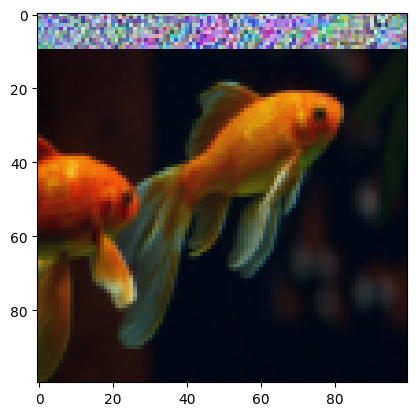

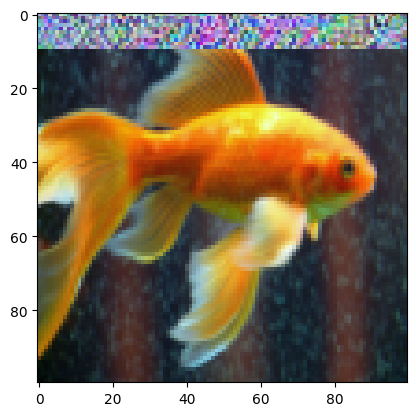

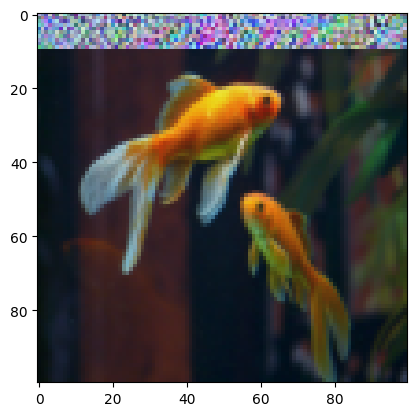

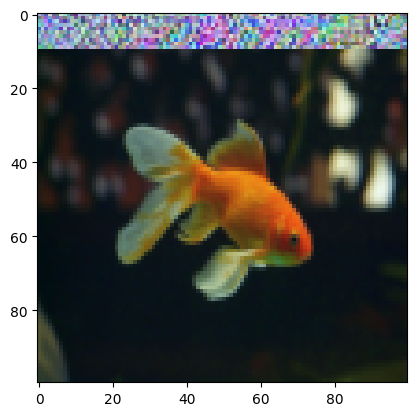

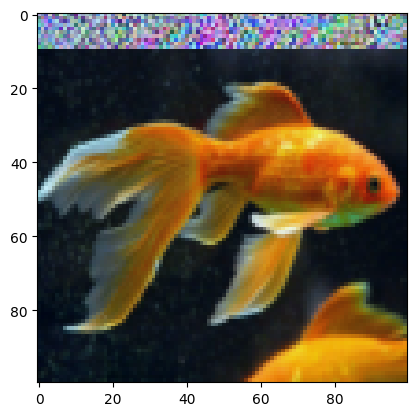

tensor(14.1693) [tensor(13.6856), tensor(17.2927), tensor(9.1075), tensor(12.2689), tensor(18.4917)]
Epoch 11
tensor(13.7350) [tensor(13.1183), tensor(17.0093), tensor(8.8568), tensor(11.9759), tensor(17.7148)]
Epoch 12
tensor(13.3652) [tensor(12.8148), tensor(16.3229), tensor(8.6528), tensor(11.7167), tensor(17.3185)]
Epoch 13
tensor(13.1031) [tensor(12.5296), tensor(16.2600), tensor(8.5191), tensor(11.3755), tensor(16.8315)]
Epoch 14
tensor(12.6699) [tensor(12.2324), tensor(15.5707), tensor(8.2791), tensor(11.1632), tensor(16.1042)]
Epoch 15
tensor(12.4181) [tensor(12.1424), tensor(15.2973), tensor(7.8943), tensor(11.0758), tensor(15.6807)]
Epoch 16
tensor(12.0530) [tensor(11.7860), tensor(14.8319), tensor(7.7460), tensor(10.6232), tensor(15.2777)]
Epoch 17
tensor(11.8562) [tensor(11.5323), tensor(14.6575), tensor(7.5287), tensor(10.3160), tensor(15.2466)]
Epoch 18
tensor(11.5300) [tensor(11.2457), tensor(14.2399), tensor(7.3471), tensor(10.0734), tensor(14.7440)]
Epoch 19
tensor(11.

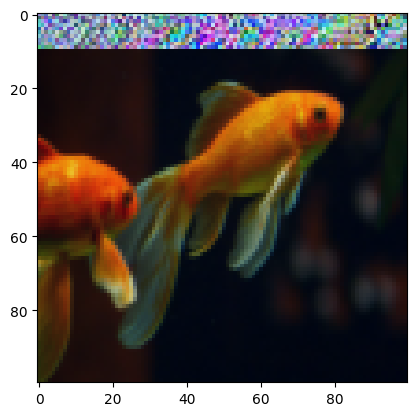

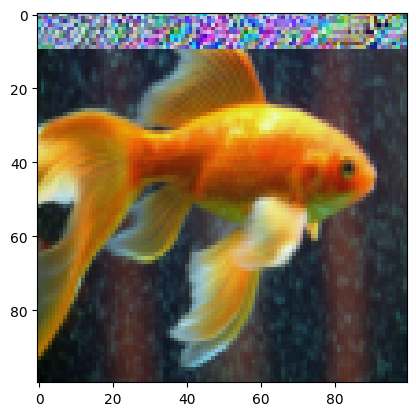

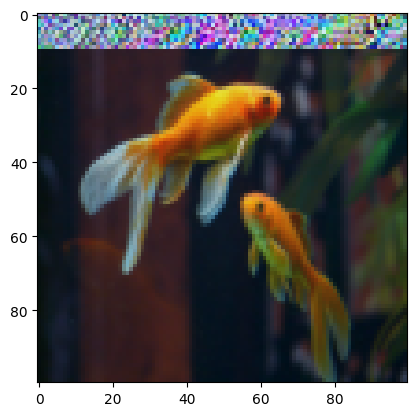

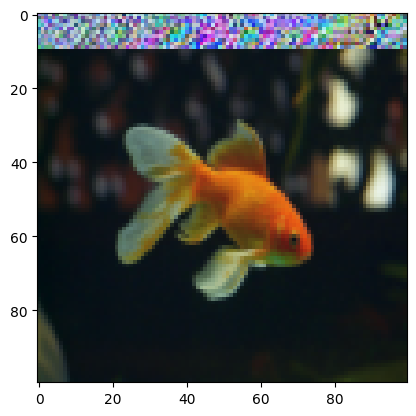

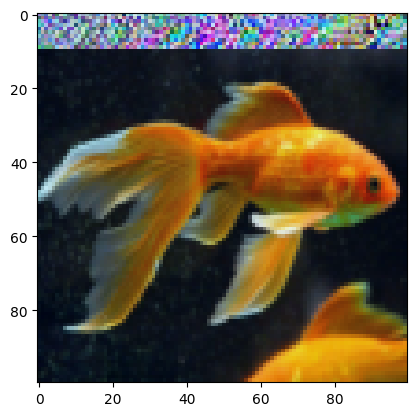

tensor(11.0864) [tensor(10.8529), tensor(13.4248), tensor(6.9869), tensor(9.7376), tensor(14.4299)]
Epoch 21
tensor(10.8387) [tensor(10.5295), tensor(13.2698), tensor(6.9065), tensor(9.5201), tensor(13.9675)]
Epoch 22
tensor(10.6719) [tensor(10.5086), tensor(12.8538), tensor(6.7323), tensor(9.3408), tensor(13.9239)]
Epoch 23
tensor(10.4843) [tensor(10.2449), tensor(12.5034), tensor(6.7827), tensor(9.3316), tensor(13.5588)]
Epoch 24
tensor(10.3985) [tensor(10.2400), tensor(12.2984), tensor(6.4350), tensor(9.2511), tensor(13.7677)]
Epoch 25
tensor(10.1282) [tensor(9.6694), tensor(12.1975), tensor(6.2252), tensor(9.0652), tensor(13.4836)]
Epoch 26
tensor(9.8532) [tensor(9.3485), tensor(11.9058), tensor(6.1024), tensor(8.6795), tensor(13.2295)]
Epoch 27
tensor(9.5760) [tensor(9.1669), tensor(11.6528), tensor(5.7964), tensor(8.4111), tensor(12.8526)]
Epoch 28
tensor(9.5142) [tensor(8.7546), tensor(11.4662), tensor(5.7952), tensor(7.8626), tensor(13.6923)]
Epoch 29
tensor(9.2249) [tensor(8.5

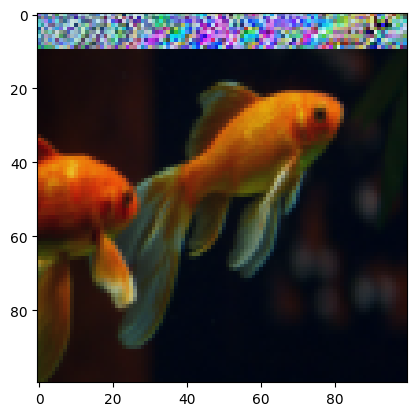

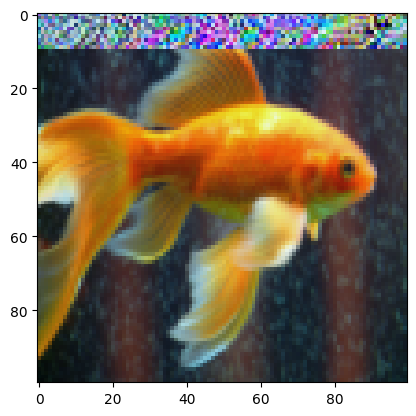

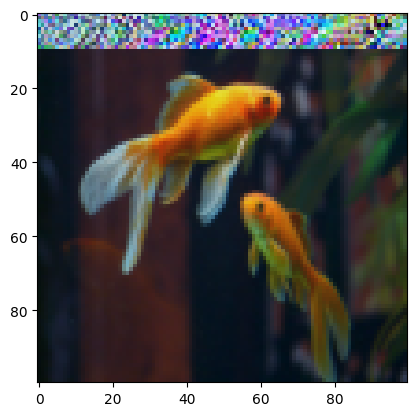

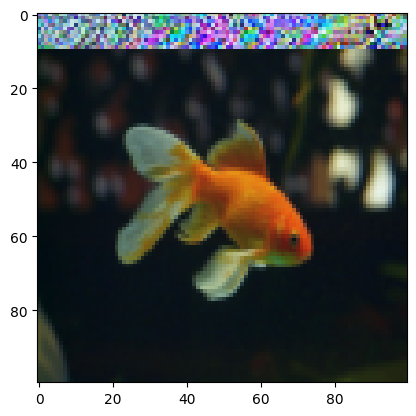

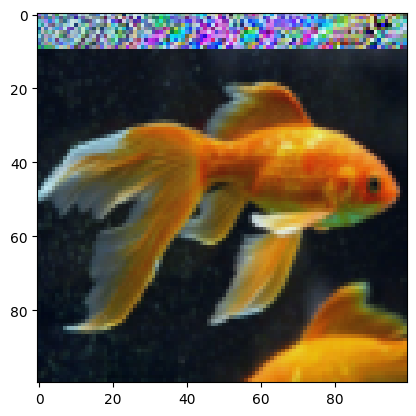

tensor(8.9803) [tensor(8.1425), tensor(11.0029), tensor(5.3430), tensor(7.3677), tensor(13.0452)]
Epoch 31
tensor(8.5453) [tensor(7.8614), tensor(10.7001), tensor(4.8111), tensor(6.9627), tensor(12.3910)]
Epoch 32
tensor(8.3499) [tensor(7.3442), tensor(10.4166), tensor(4.9961), tensor(6.5086), tensor(12.4838)]
Epoch 33
tensor(7.9897) [tensor(6.9272), tensor(10.0913), tensor(4.4940), tensor(6.3586), tensor(12.0775)]
Epoch 34
tensor(7.6128) [tensor(6.6556), tensor(9.5556), tensor(4.3194), tensor(6.0439), tensor(11.4897)]
Epoch 35
tensor(7.4626) [tensor(6.1279), tensor(9.5920), tensor(4.2375), tensor(5.5613), tensor(11.7942)]
Epoch 36
tensor(7.1430) [tensor(5.7823), tensor(9.3102), tensor(3.6712), tensor(5.4764), tensor(11.4747)]
Epoch 37
tensor(6.8652) [tensor(5.5742), tensor(9.0051), tensor(3.4545), tensor(5.3831), tensor(10.9093)]
Epoch 38
tensor(6.6432) [tensor(4.9973), tensor(8.7224), tensor(3.3531), tensor(5.1769), tensor(10.9661)]
Epoch 39
tensor(6.2931) [tensor(4.8705), tensor(8.4

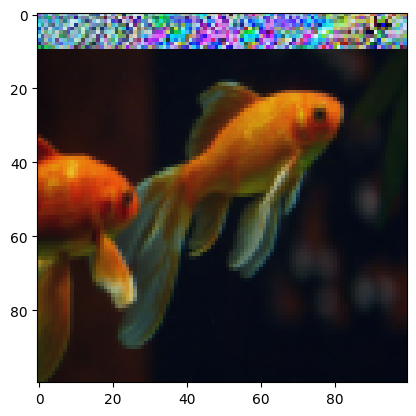

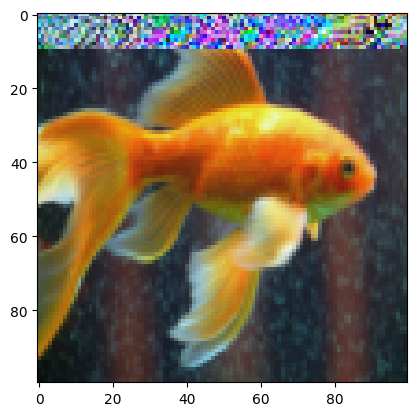

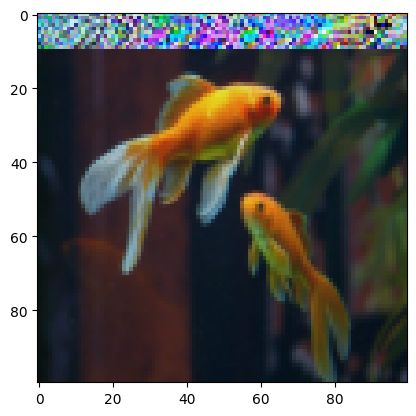

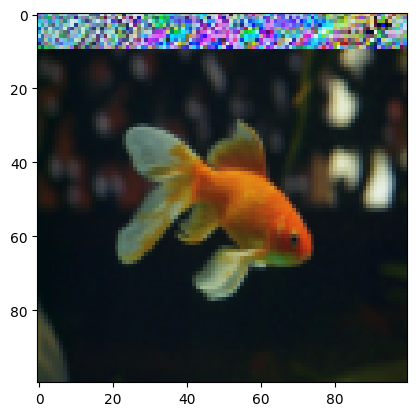

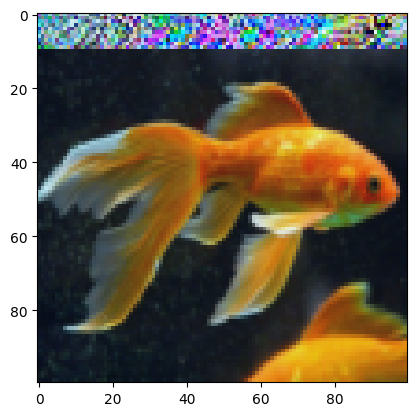

tensor(6.0646) [tensor(4.5670), tensor(8.1830), tensor(2.9342), tensor(4.8126), tensor(9.8264)]
Epoch 41
tensor(5.7780) [tensor(4.4582), tensor(7.8232), tensor(2.7248), tensor(4.6538), tensor(9.2300)]
Epoch 42
tensor(5.5063) [tensor(4.1950), tensor(7.3332), tensor(2.8336), tensor(4.2579), tensor(8.9117)]
Epoch 43
tensor(5.5164) [tensor(4.1597), tensor(7.6115), tensor(2.3306), tensor(4.0871), tensor(9.3932)]
Epoch 44
tensor(5.0641) [tensor(4.0051), tensor(6.9648), tensor(1.9639), tensor(3.9289), tensor(8.4580)]
Epoch 45
tensor(4.6980) [tensor(3.4556), tensor(6.6524), tensor(2.2623), tensor(3.5825), tensor(7.5373)]
Epoch 46
tensor(4.1754) [tensor(3.1148), tensor(6.5837), tensor(1.1171), tensor(3.2724), tensor(6.7890)]
Epoch 47
tensor(3.5804) [tensor(2.8385), tensor(5.7272), tensor(1.1750), tensor(2.6634), tensor(5.4979)]
Epoch 48
tensor(3.0873) [tensor(2.2885), tensor(4.7684), tensor(1.1498), tensor(2.2359), tensor(4.9938)]
Epoch 49
tensor(2.4989) [tensor(1.7046), tensor(4.3138), tensor(

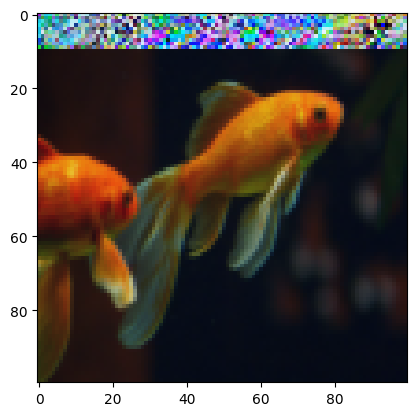

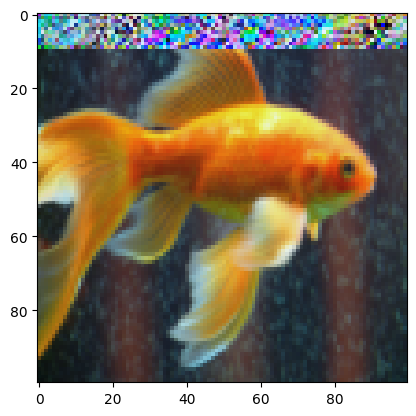

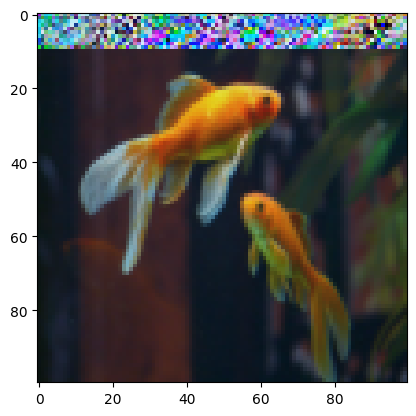

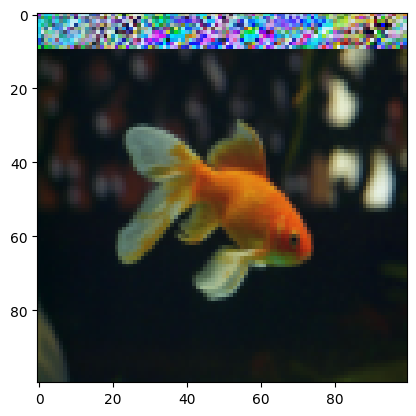

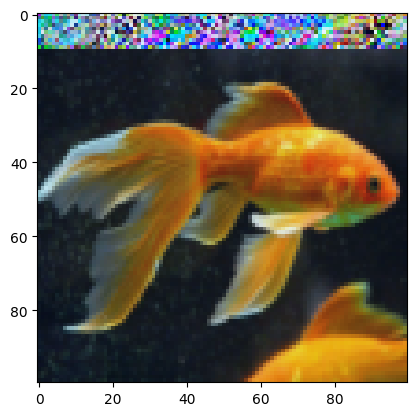

tensor(2.1854) [tensor(1.3033), tensor(4.0443), tensor(0.7665), tensor(1.5534), tensor(3.2593)]
Epoch 51
tensor(1.8039) [tensor(1.0546), tensor(3.3162), tensor(0.6746), tensor(1.5493), tensor(2.4249)]
Epoch 52
tensor(1.4233) [tensor(0.8280), tensor(2.5141), tensor(0.4985), tensor(1.4413), tensor(1.8348)]
Epoch 53
tensor(1.4099) [tensor(0.9055), tensor(2.0575), tensor(0.3409), tensor(1.4004), tensor(2.3450)]
Epoch 54
tensor(1.0122) [tensor(0.5858), tensor(1.4699), tensor(0.4629), tensor(1.3316), tensor(1.2109)]
Epoch 55
tensor(0.9544) [tensor(0.5589), tensor(1.1583), tensor(0.5249), tensor(0.9933), tensor(1.5368)]
Epoch 56
tensor(0.6570) [tensor(0.4915), tensor(0.7695), tensor(0.3170), tensor(0.9661), tensor(0.7408)]
Epoch 57
tensor(0.5465) [tensor(0.4882), tensor(0.6539), tensor(0.1919), tensor(0.6995), tensor(0.6989)]
Epoch 58
tensor(0.4232) [tensor(0.2567), tensor(0.6456), tensor(0.2137), tensor(0.5267), tensor(0.4735)]
Epoch 59
tensor(0.3605) [tensor(0.2894), tensor(0.4615), tensor(

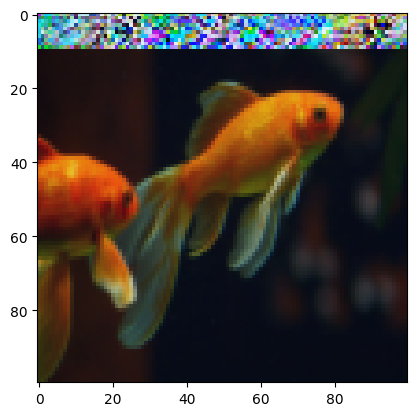

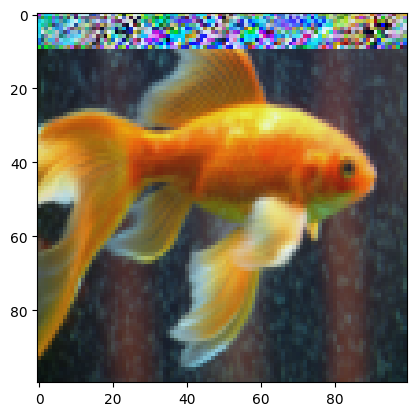

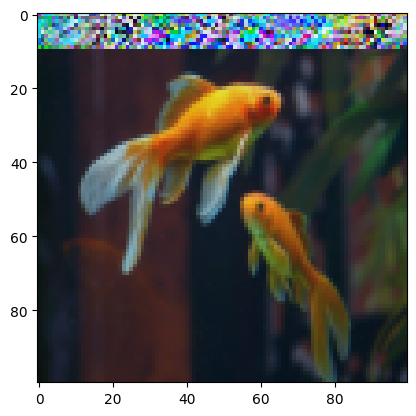

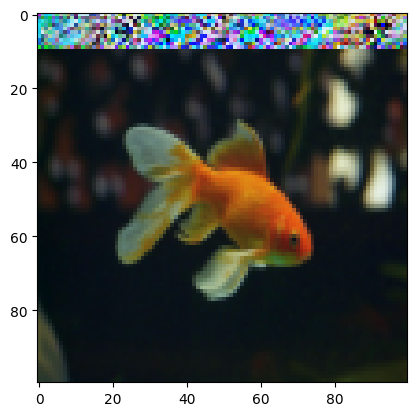

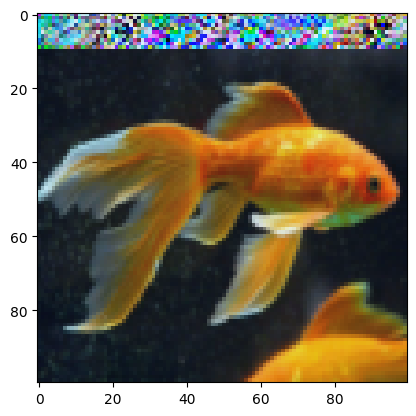

tensor(0.3045) [tensor(0.2777), tensor(0.3441), tensor(0.1494), tensor(0.4001), tensor(0.3511)]
Epoch 61
tensor(0.2590) [tensor(0.2025), tensor(0.3119), tensor(0.1153), tensor(0.3564), tensor(0.3085)]
Epoch 62
tensor(0.2273) [tensor(0.1595), tensor(0.2807), tensor(0.1122), tensor(0.3134), tensor(0.2706)]
Epoch 63
tensor(0.2027) [tensor(0.1338), tensor(0.2631), tensor(0.1137), tensor(0.2850), tensor(0.2179)]
Epoch 64
tensor(0.1890) [tensor(0.1316), tensor(0.2279), tensor(0.1078), tensor(0.2665), tensor(0.2112)]
Epoch 65
tensor(0.1762) [tensor(0.1227), tensor(0.2095), tensor(0.0982), tensor(0.2416), tensor(0.2088)]
Epoch 66
tensor(0.1654) [tensor(0.1162), tensor(0.1904), tensor(0.0998), tensor(0.2219), tensor(0.1988)]
Epoch 67
tensor(0.1556) [tensor(0.1132), tensor(0.1724), tensor(0.0994), tensor(0.2110), tensor(0.1821)]
Epoch 68
tensor(0.1486) [tensor(0.1089), tensor(0.1649), tensor(0.0938), tensor(0.2016), tensor(0.1740)]
Epoch 69
tensor(0.1423) [tensor(0.1032), tensor(0.1564), tensor(

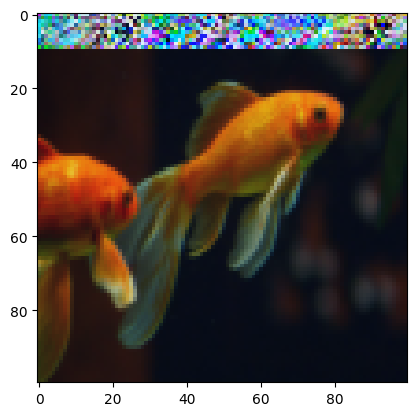

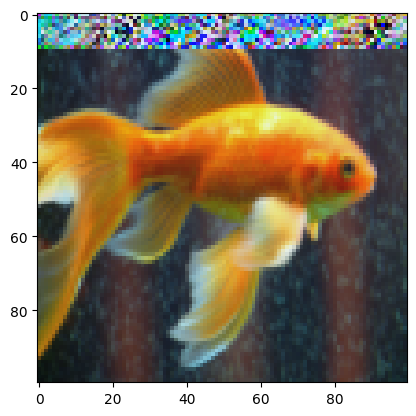

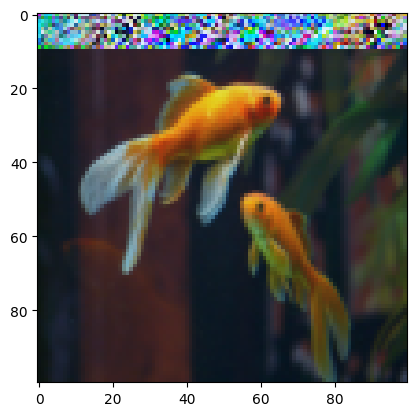

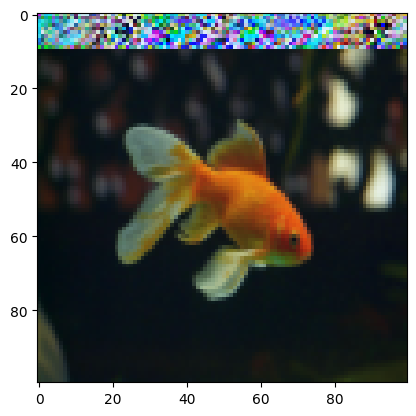

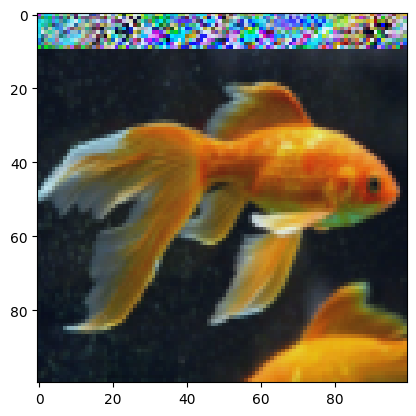

tensor(0.1364) [tensor(0.0987), tensor(0.1478), tensor(0.0843), tensor(0.1868), tensor(0.1647)]
Epoch 71
tensor(0.1317) [tensor(0.0942), tensor(0.1431), tensor(0.0805), tensor(0.1804), tensor(0.1602)]
Epoch 72
tensor(0.1274) [tensor(0.0900), tensor(0.1372), tensor(0.0773), tensor(0.1748), tensor(0.1576)]
Epoch 73
tensor(0.1235) [tensor(0.0884), tensor(0.1330), tensor(0.0756), tensor(0.1683), tensor(0.1521)]
Epoch 74
tensor(0.1203) [tensor(0.0855), tensor(0.1301), tensor(0.0725), tensor(0.1636), tensor(0.1496)]
Epoch 75
tensor(0.1166) [tensor(0.0816), tensor(0.1276), tensor(0.0706), tensor(0.1597), tensor(0.1437)]
Epoch 76
tensor(0.1139) [tensor(0.0797), tensor(0.1229), tensor(0.0700), tensor(0.1549), tensor(0.1422)]
Epoch 77
tensor(0.1105) [tensor(0.0771), tensor(0.1190), tensor(0.0691), tensor(0.1507), tensor(0.1365)]
Epoch 78
tensor(0.1079) [tensor(0.0752), tensor(0.1175), tensor(0.0667), tensor(0.1476), tensor(0.1324)]
Epoch 79
tensor(0.1057) [tensor(0.0730), tensor(0.1150), tensor(

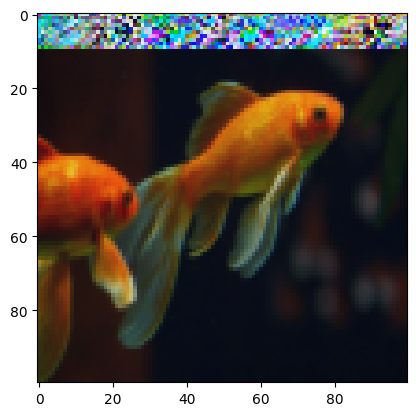

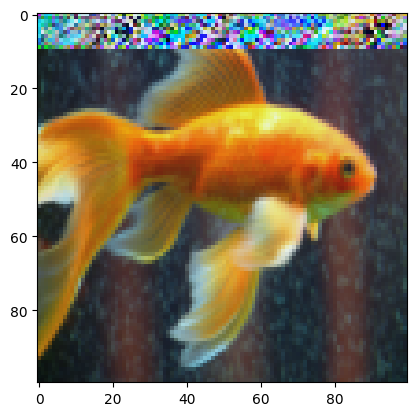

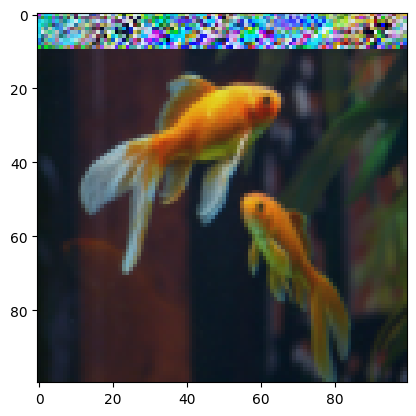

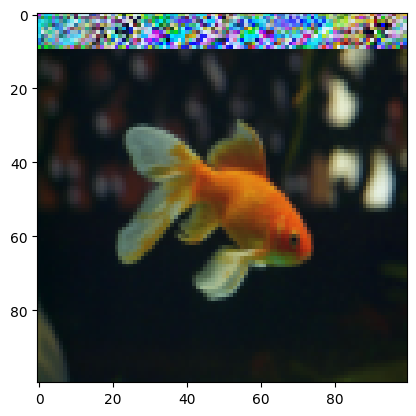

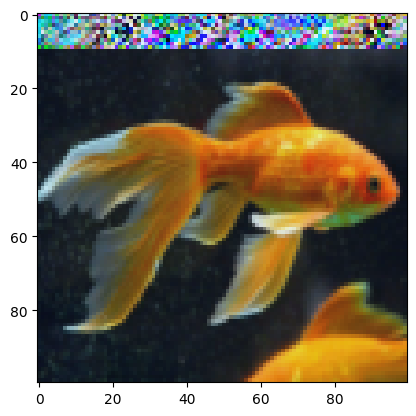

tensor(0.1028) [tensor(0.0703), tensor(0.1101), tensor(0.0656), tensor(0.1400), tensor(0.1277)]
Epoch 81
tensor(0.1005) [tensor(0.0686), tensor(0.1072), tensor(0.0643), tensor(0.1372), tensor(0.1251)]
Epoch 82
tensor(0.0984) [tensor(0.0663), tensor(0.1053), tensor(0.0626), tensor(0.1337), tensor(0.1240)]
Epoch 83
tensor(0.0959) [tensor(0.0641), tensor(0.1009), tensor(0.0617), tensor(0.1312), tensor(0.1217)]
Epoch 84
tensor(0.0937) [tensor(0.0620), tensor(0.0985), tensor(0.0596), tensor(0.1301), tensor(0.1184)]
Epoch 85
tensor(0.0919) [tensor(0.0604), tensor(0.0968), tensor(0.0587), tensor(0.1254), tensor(0.1182)]
Epoch 86
tensor(0.0894) [tensor(0.0579), tensor(0.0945), tensor(0.0578), tensor(0.1225), tensor(0.1144)]
Epoch 87
tensor(0.0876) [tensor(0.0573), tensor(0.0922), tensor(0.0565), tensor(0.1207), tensor(0.1113)]
Epoch 88
tensor(0.0859) [tensor(0.0567), tensor(0.0888), tensor(0.0558), tensor(0.1184), tensor(0.1095)]
Epoch 89
tensor(0.0841) [tensor(0.0559), tensor(0.0870), tensor(

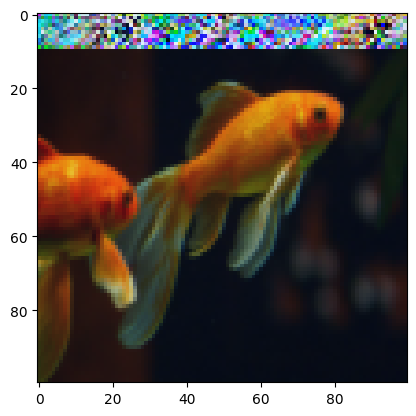

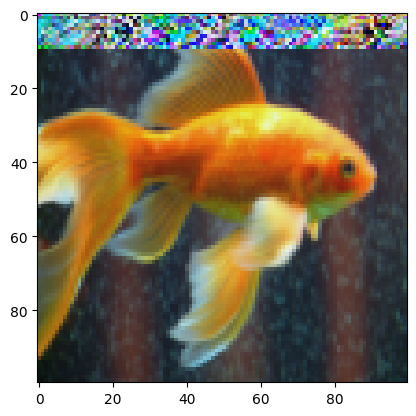

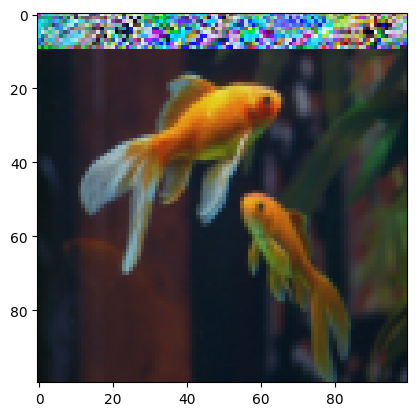

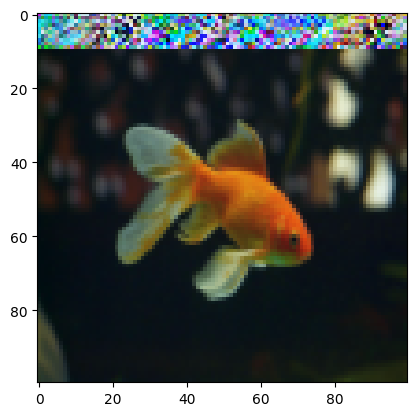

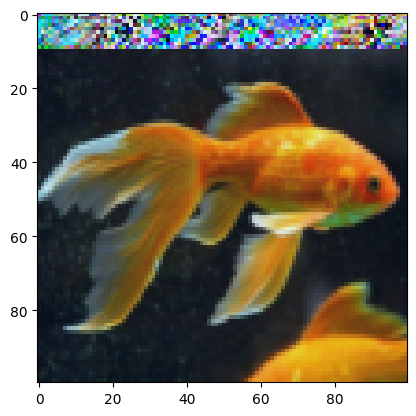

tensor(0.0829) [tensor(0.0553), tensor(0.0858), tensor(0.0536), tensor(0.1139), tensor(0.1059)]
Epoch 91
tensor(0.0813) [tensor(0.0535), tensor(0.0843), tensor(0.0528), tensor(0.1122), tensor(0.1040)]
Epoch 92
tensor(0.0800) [tensor(0.0522), tensor(0.0824), tensor(0.0512), tensor(0.1098), tensor(0.1044)]
Epoch 93
tensor(0.0786) [tensor(0.0516), tensor(0.0808), tensor(0.0504), tensor(0.1088), tensor(0.1013)]
Epoch 94
tensor(0.0774) [tensor(0.0508), tensor(0.0790), tensor(0.0497), tensor(0.1076), tensor(0.1001)]
Epoch 95
tensor(0.0763) [tensor(0.0499), tensor(0.0777), tensor(0.0484), tensor(0.1071), tensor(0.0982)]
Epoch 96
tensor(0.0751) [tensor(0.0493), tensor(0.0759), tensor(0.0476), tensor(0.1049), tensor(0.0977)]
Epoch 97
tensor(0.0739) [tensor(0.0488), tensor(0.0748), tensor(0.0477), tensor(0.1030), tensor(0.0953)]
Epoch 98
tensor(0.0730) [tensor(0.0483), tensor(0.0741), tensor(0.0464), tensor(0.1012), tensor(0.0951)]
Epoch 99
tensor(0.0719) [tensor(0.0478), tensor(0.0733), tensor(

In [ ]:
def calculate_strip():
  param = torch.rand((3, STRIP_HEIGHT, SIZE), requires_grad=True, device=device)
  optimizer = torch.optim.Adam([param], lr=0.1)

  for epoch in range(100):
    print(f'Epoch {epoch}')
    losses = []
    for im in images:
      optimizer.zero_grad()
      img_tensor = resize(im.convert("RGB")).to(device)
      img_tensor[:, :STRIP_HEIGHT, :] = torch.nn.functional.sigmoid(param)
      img_tensor = normalize_colors(img_tensor)
      img_tensor = img_tensor.unsqueeze(0)

      pred = model(img_tensor)[0]
      # It is important to use log_softmax here, as otherwise one can get stuck
      # in a situation where some images are already solved, while for the
      # rest the probabilities are very low and gradients vanish.
      loss = -torch.nn.functional.log_softmax(pred)[2]
      losses.append(loss.detach())
      loss.backward()
      optimizer.step()
      if epoch % 10 == 0:
        img_tensor_c = img_tensor.clone().detach()
        img_tensor_c -= img_tensor_c.min()
        img_tensor_c /= img_tensor_c.max()
        plt.imshow(img_tensor_c[0].permute(1, 2, 0).cpu())
        plt.show()
    print(torch.mean(torch.stack(losses)), losses)
  return torch.nn.functional.sigmoid(param).detach()


strip = calculate_strip()
for im in images:
  p_goldfish, p_shark = calc_predictions(im, strip)
  print(f'Probability of being a goldfish is {p_goldfish}, shark is {p_shark}.')